In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [2]:
import pandas as pd
import numpy as np
import re
import gc  # Garbage Collector zur Speicherverwaltung


def clean_fuel_consumption(fuel_type, value):
    """
    Extrahiert den Verbrauch in l/100 km als float.
    Alle anderen Einheiten und ungültige Werte werden zu NaN.
    """
    if fuel_type in ['Diesel', 'Petrol', 'Hybrid', 'LPG', 'Electric', 'Diesel Hybrid', 'Other', 'Unknown', 'Ethanol']:
        if pd.isna(value) or 'l/100' not in str(value):
            return np.nan
        try:
            return float(str(value).split(' ')[0].replace(',', '.'))
        except:
            return np.nan

    elif fuel_type == 'CNG':
        if 'kg/100' in str(value):
            try:
                return round(float(str(value).split(' ')[0].replace(',', '.')) / 0.18, 2)
            except:
                return np.nan
        elif 'l/100' in str(value):
            try:
                return float(str(value).split(' ')[0].replace(',', '.'))
            except:
                return np.nan
        else:
            return np.nan
    elif fuel_type == 'Hydrogen':
        if 'kg/100' in str(value):
            try:
                kg = float(str(value).split()[0].replace(',', '.'))
                return round(kg * 33.33 / 8.6, 2)
            except:
                return np.nan
        else:
            return np.nan
        
    return np.nan

def preprocessing_pipeline(df):


    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    # Nur relevante fuel types
    df = df[df['fuel_type'].isin(['Diesel', 'Petrol', 'Hybrid', 'LPG', 'Electric', 'Diesel Hybrid', 'Other', 'Unknown', 'Ethanol', 'CNG', 'Hydrogen'])].reset_index(drop=True)

    # Fuel consumption in l/100 km bereinigen
    df['fuel_consumption_l_100km'] = df.apply(
    lambda row: clean_fuel_consumption(row['fuel_type'], row['fuel_consumption_l_100km']),
    axis=1
    )

    # E-Autos: Verbrauch auf 0 setzen, Reichweite extrahieren
    e_mask = df['fuel_type'] == 'Electric'
    df.loc[e_mask, 'fuel_consumption_l_100km'] = 0.0
    # Extrahiere Reichweite aus fuel_consumption_g_km
    range_mask = e_mask & df['fuel_consumption_g_km'].astype(str).str.contains(r'km Reichweite', na=False)
    df.loc[range_mask, 'electric_range'] = (
        df.loc[range_mask, 'fuel_consumption_g_km']
          .astype(str)
          .str.extract(r'(\d+)', expand=False)
          .astype(float)
    )
    # Nicht-Elektro auf 0
    df.loc[~e_mask, 'electric_range'] = 0.0

    # Numerische Typen setzen
    for col in ['power_ps', 'power_kw']:
        df[col] = df[col].astype(float)
    df['mileage_in_km'] = pd.to_numeric(df['mileage_in_km'], errors='coerce')
    df['price_in_euro'] = pd.to_numeric(df['price_in_euro'], errors='coerce')
    df['year'] = pd.to_numeric(df['year'], errors='coerce')

    # Datum in numerische Merkmale umwandeln
    df['registration_date'] = pd.to_datetime(df['registration_date'], format='%m/%Y', errors='coerce')
    df['registration_month'] = df['registration_date'].dt.month

    # Nicht mehr benötigte Spalten entfernen
    #df.drop(columns=['registration_date', 'power_kw', 'offer_description', 'fuel_consumption_g_km'], inplace=True)

    # Speicher freigeben
    gc.collect()

    return df

In [3]:
df  = pd.read_csv('../data.csv')

In [4]:
yearsToFilter = list(df['year'].unique()[:29])  # wegen Scraping Fehler
filt = [val in yearsToFilter for val in df['year']]
df = df[filt]


df = df.drop_duplicates(subset= ['brand', 'model', 'color', 'registration_date', 'year',
       'price_in_euro', 'power_kw', 'power_ps', 'transmission_type',
       'fuel_type', 'fuel_consumption_l_100km', 'fuel_consumption_g_km',
       'mileage_in_km', 'offer_description']) 

In [5]:
df = preprocessing_pipeline(df)

In [6]:
numeric  = list(df.select_dtypes('number').columns)

In [7]:
df[(df['fuel_type'] != 'Electric')][numeric]

,year,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,mileage_in_km,electric_range,registration_month
0,1995,1300,148.0,201.0,10.9,160500.0,0.0,10
1,1995,24900,191.0,260.0,NaN,190000.0,0.0,2
2,1995,5900,110.0,150.0,NaN,129000.0,0.0,2
3,1995,4900,110.0,150.0,9.5,189500.0,0.0,7
4,1996,17950,132.0,179.0,7.2,96127.0,0.0,11
...,...,...,...,...,...,...,...,...
244536,2023,54500,145.0,197.0,5.6,5900.0,0.0,3
244537,2023,57990,192.0,261.0,NaN,1229.0,0.0,4
244538,2023,89690,173.0,235.0,7.6,4900.0,0.0,3
244539,2023,61521,145.0,197.0,4.7,1531.0,0.0,5


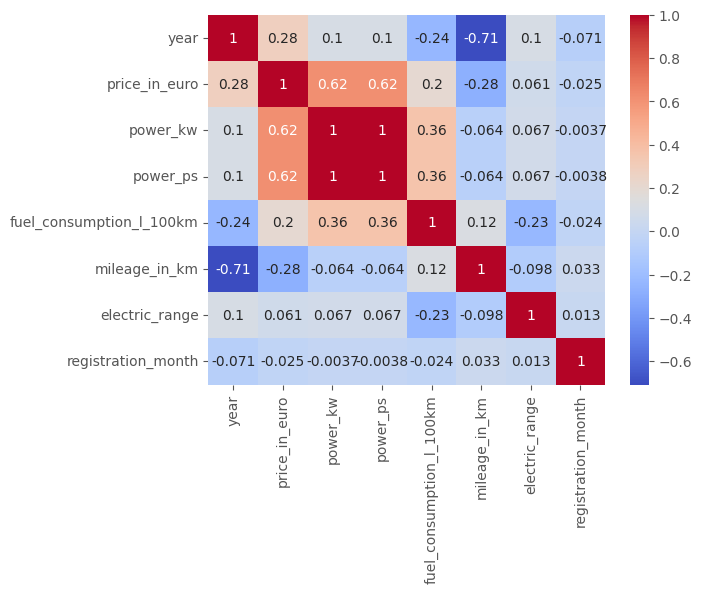

In [8]:
sns.heatmap(df[numeric].corr(), annot=True, cmap='coolwarm')
plt.show()

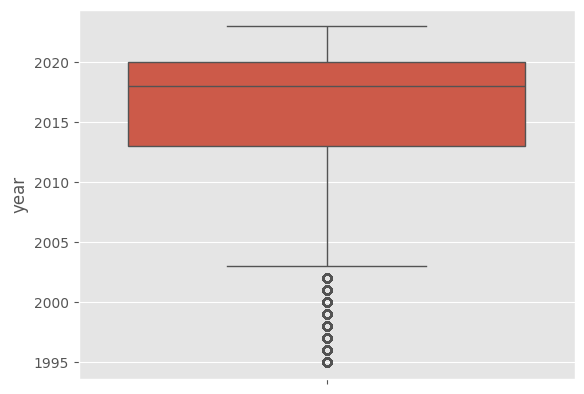

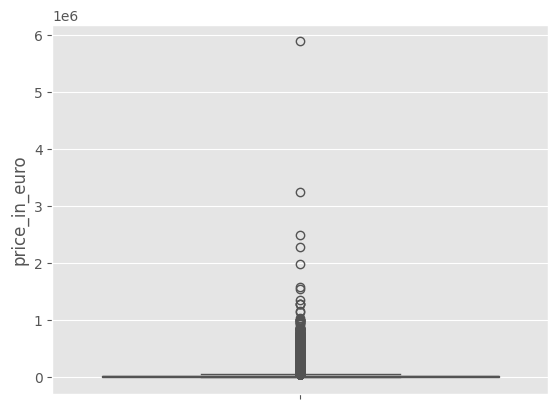

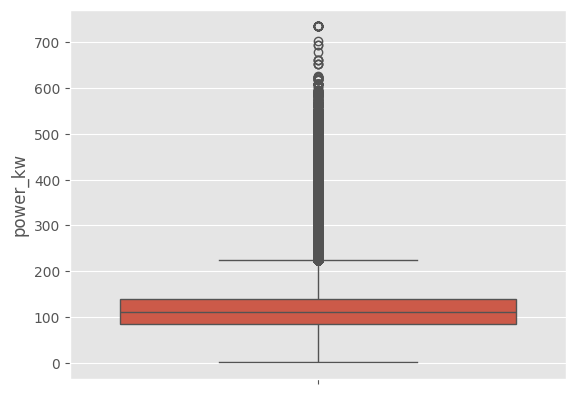

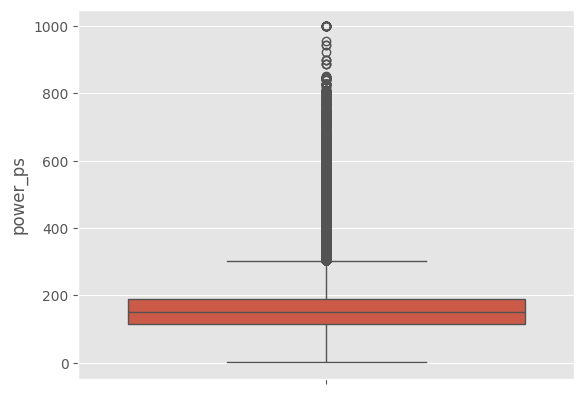

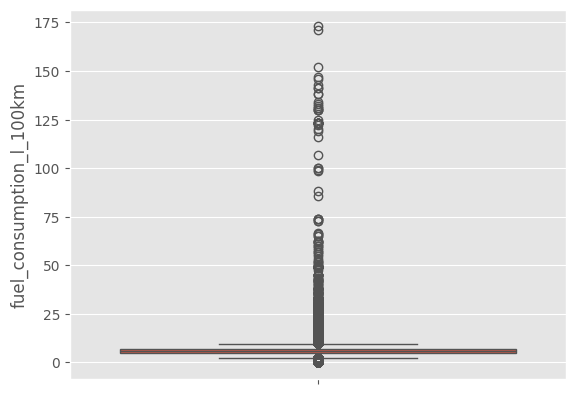

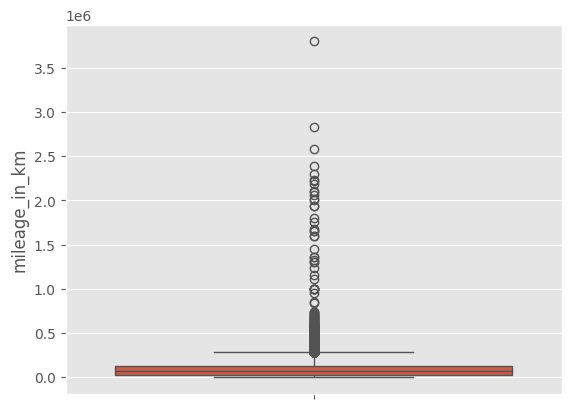

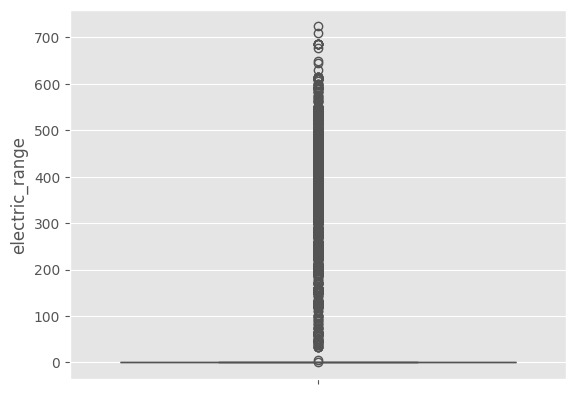

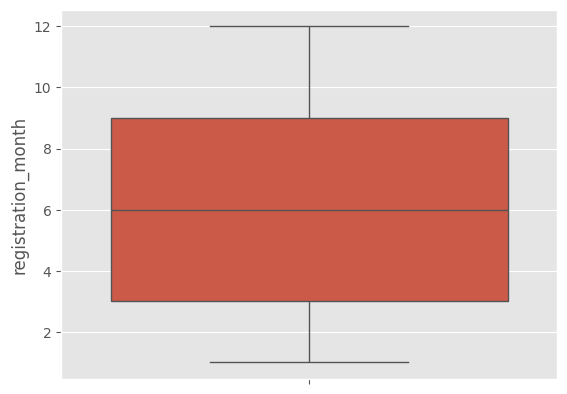

In [9]:
for feature in numeric:
    sns.boxplot(y= feature, data= df)
    plt.show()

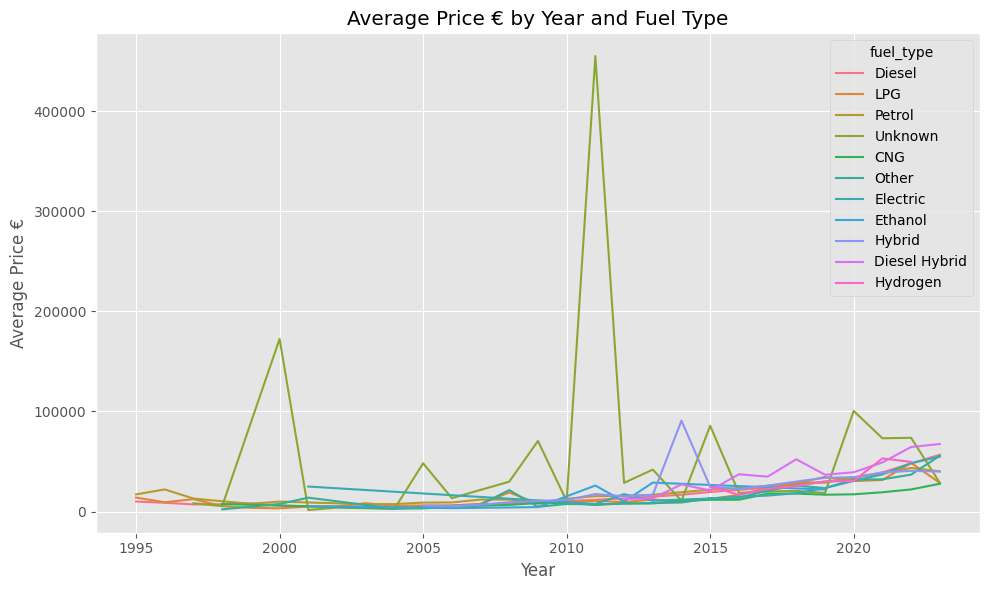

In [10]:
df_grouped = (
    df
    .groupby(['year', 'fuel_type'])['price_in_euro']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=df_grouped,
    x='year',
    y='price_in_euro',
    hue='fuel_type'
)
ax.set_title('Average Price € by Year and Fuel Type')
ax.set_xlabel('Year')
ax.set_ylabel('Average Price €')
plt.tight_layout()
plt.show()

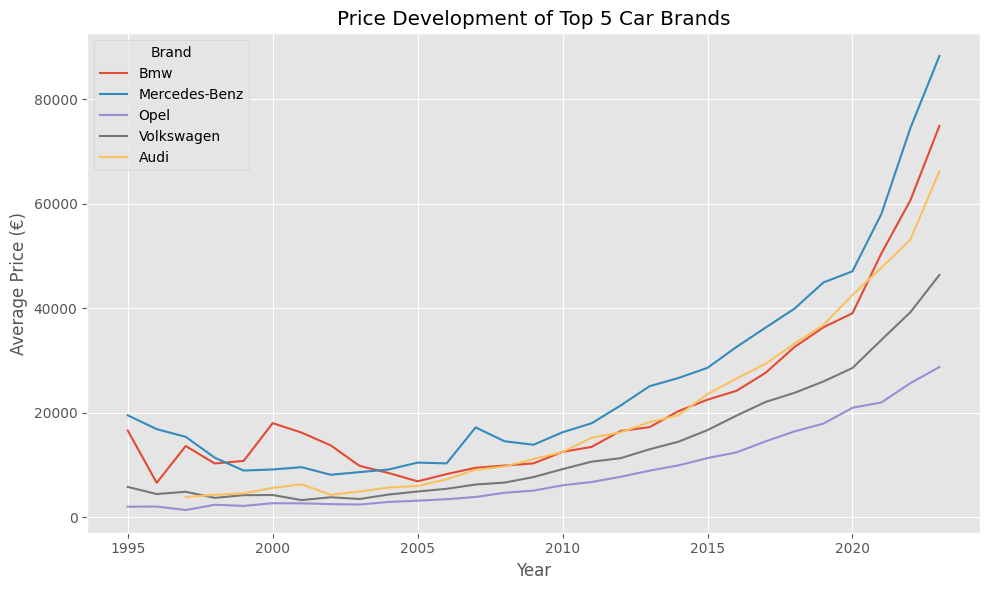

In [11]:
top5_brands = df['brand'].value_counts().nlargest(5).index

# Filter auf Top 5 Marken
filtered_df = df[df['brand'].isin(top5_brands)]

# Gruppieren: Durchschnittspreis pro Jahr und Marke
grouped = (
    filtered_df
    .groupby(['year', 'brand'])['price_in_euro']
    .mean()
    .reset_index()
)

# 💡 Marken-Namen in Großbuchstaben umwandeln
grouped['brand'] = grouped['brand'].str.title()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='year', y='price_in_euro', hue='brand')
plt.title("Price Development of Top 5 Car Brands")
plt.xlabel("Year")
plt.ylabel("Average Price (€)")
plt.legend(title='Brand')
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

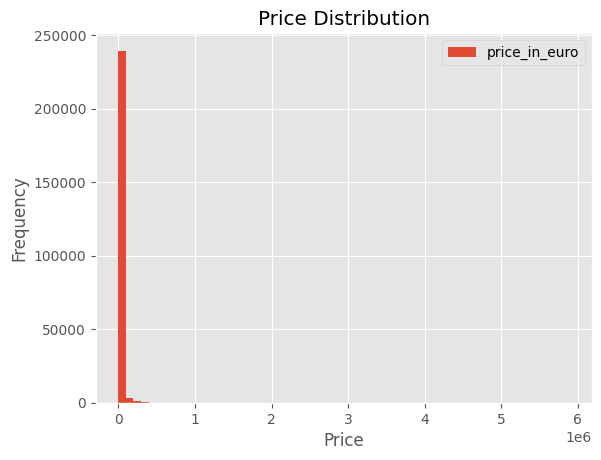

In [12]:
plt.figure(figsize=(10, 5))
df[['price_in_euro']].plot(kind='hist', bins=60)
plt.xlabel('Price')
plt.title('Price Distribution')
plt.show()